In [57]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

# Modeling Micrograd

In [226]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    # Checks if order of operands is a valid multiplication which is already defined
    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other):
        return other * self**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    def __repr__(self):
        return f"Value(data={self.data})"

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1)/(math.exp(2 * x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        def topo_sort(v):
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v._prev:
                        build_topo(child)
                    topo.append(v)
            build_topo(self)
            return topo

        self.grad = 1
        for node in reversed(topo_sort(self)):
            node._backward()

In [32]:
a = Value(2.0)
4 - a

Value(data=2.0)

We now implement Topological sort to call the `_backward` function on its own. It basically lies out all children of a prent node from left to right. So basically the root node adds itself only after all the children have been added to the list `topo`.

To find the `_backward()` fucntions everywhere, we just use the local derivatives of each of the functions in that place, multiplied by the forward gradient due to chain rule. But to prevent the case where two same variables are used in an operation giving the wrong gradient, instead of assigneing the grads, we accumulate them using `+=`.

We remember to use $\frac{d(tanh(x))}{dx} = 1 - tanh^2(x)$.

In [38]:
from graphviz import Digraph

def trace(root):
    # Build a set of nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'}) # LR: left to right

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular node ('record')
        dot.node(name = uid, label = f"Label: {n.label} | Data: {n.data:.4f} | Grad: {n.grad:.4f}", shape = 'record')
        if n._op:
            # if this value is the result of an operation, create an op (circular) node
            dot.node(name = uid + n._op, label = n._op, shape = 'circle')
            # and connect the op node to the value node
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

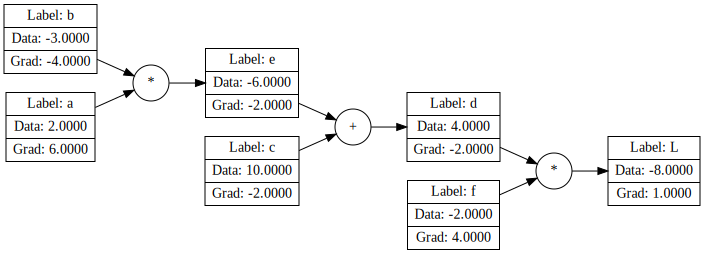

In [39]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L.backward()
draw_dot(L)

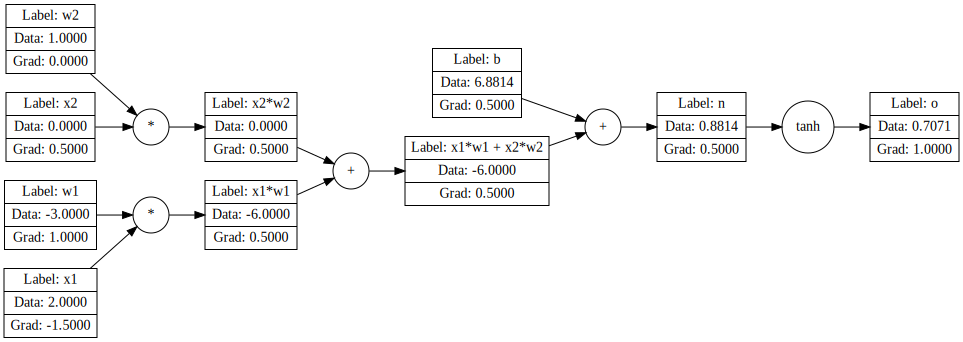

In [47]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
conc = x1w1 + x2w2; conc.label = 'x1*w1 + x2*w2'
n = conc + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

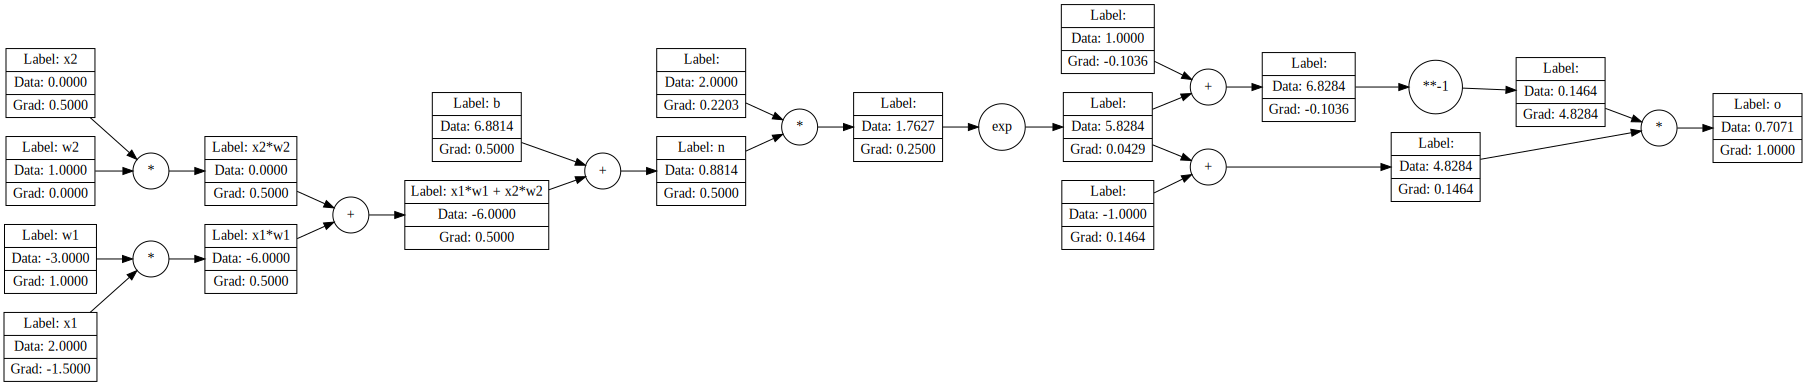

In [51]:
# inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
conc = x1w1 + x2w2; conc.label = 'x1*w1 + x2*w2'
n = conc + b; n.label = 'n'
# Simulate tanh()
e = (2 * n).exp()
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()
draw_dot(o)

# Working with PyTorch

In [56]:
import torch

x1 = torch.tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print('o', o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

o 0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Working with Neurons

In [86]:
class Neuron:
    # nin -> Number of neurons
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [87]:
class Layer:
    # nin -> number of layers, nout -> number of neurons in each layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

## Multilayer Perceptron

**Inside the constructor**:
- A list called `sz` is created. This list starts with the input size `nin` and then appends the sizes of the output layers specified in the `nouts` list. This list effectively defines the size of each layer in the MLP, including the input layer.
- The `self.layers` attribute is initialized as a list of `Layer` objects. For each element in the nouts list, a new Layer is created. The input size for each Layer is taken from `sz[i]` and the output size is taken from `sz[i + 1]`, effectively connecting the layers sequentially.

In [ ]:
class MLP:
    # nin -> number of layers, nouts -> list of the sizes of layers we want in the MLP
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __zero_grad__(self):
        for p in self.parameters():
            p.grad = 0.0

    def optimize(self, learning_rate, cycles, inp, out):
        for k in range(cycles):
            # forward pass
            ypred = [self.__call__(x) for x in inp]
            loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ypred, out))
            # zero grad the gradients
            self.__zero_grad__()
            # backward propagtion
            loss.backward()
            for p in self.parameters():
                # update (gradient descent)
                p.data += -learning_rate * p.grad
        return ypred, loss

In [274]:
# Setup the neural network
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
len(n.parameters())

41

In [275]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]
# Initial predictions and loss
ypred = [n(x) for x in xs]
loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ypred, ys))
print(f"Predictions: {ypred} \nLoss: {loss}")

Predictions: [Value(data=0.029982327146947603), Value(data=0.12345519945635325), Value(data=-0.28171804605075007), Value(data=-0.3422856451859355)] 
Loss: Value(data=4.520745589474141)


In [286]:
# Do the backprop `it` number of times
it = 10
lr = 0.01

# ---- The following code is already done by the optimize function -----#
# for k in range(it):
#     # forward pass
#     ypred = [n(x) for x in xs]
#     loss = sum((yout - ygt) ** 2 for yout, ygt in zip(ypred, ys))
#     for p in n.parameters():
#         # zero grad the gradients
#         p.grad = 0.0
#     # backward propagtion
#     loss.backward()
#     for p in n.parameters():
#         # update (gradient descent)
#         p.data += -lr * p.grad
#     ypred = [n(x) for x in xs]
#     print(f"{k + 1}: {loss}")
# ----------------------------------------------------------------------#

# Final predictions
ypred, loss = n.optimize(lr, it, xs, ys)
print(f"Predictions: {ypred} \nLoss: {loss}")

Predictions: [Value(data=0.9563263099682612), Value(data=-0.950478646469672), Value(data=-0.8699772397794993), Value(data=0.8849171977608197)] 
Loss: Value(data=0.034894828394785526)
